In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras

import random
import pathlib

In [2]:
data_dir = pathlib.Path("data/training_data/")


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(100, 100),
  batch_size=32,
  color_mode="grayscale",
  )
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100),
  batch_size=32,
  color_mode="grayscale")

Found 8022 files belonging to 14 classes.
Using 6418 files for training.


2023-04-08 16:22:11.006916: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 8022 files belonging to 14 classes.
Using 1604 files for validation.


(32, 100, 100, 1)
(32,)


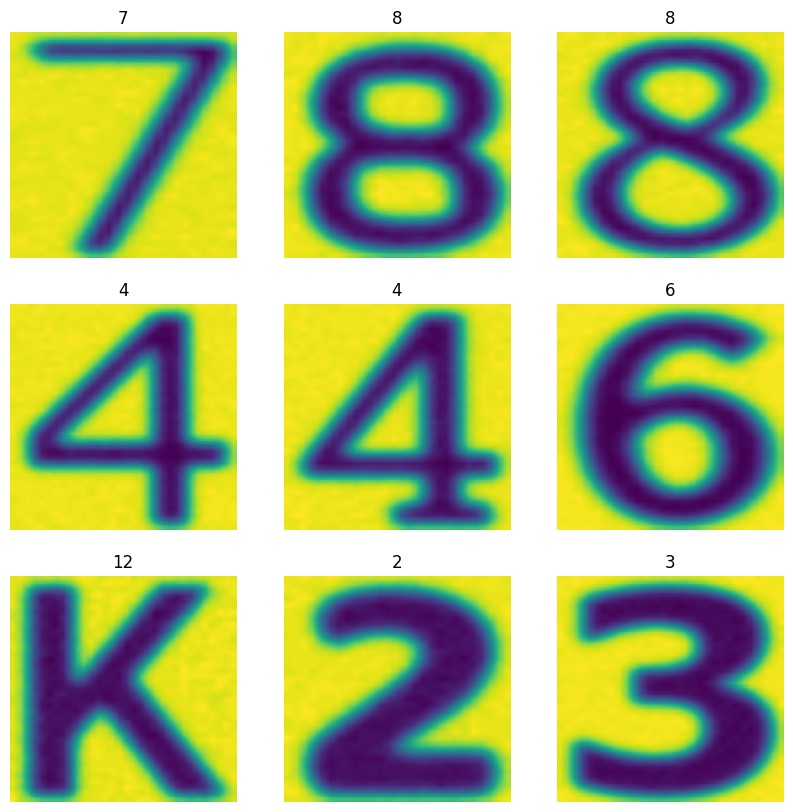

In [4]:
# Display a few images from the training set
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# print the shape of the images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [5]:
# Lets create a model
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(14, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 28224)             0

In [6]:
# Lets train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
201/201 [==============================] - 26s 126ms/step - loss: 1.7016 - accuracy: 0.8503 - val_loss: 0.2520 - val_accuracy: 0.9483
Epoch 2/10
201/201 [==============================] - 25s 127ms/step - loss: 0.1341 - accuracy: 0.9670 - val_loss: 0.1266 - val_accuracy: 0.9738
Epoch 3/10
201/201 [==============================] - 25s 124ms/step - loss: 0.0677 - accuracy: 0.9807 - val_loss: 0.1372 - val_accuracy: 0.9738
Epoch 4/10
201/201 [==============================] - 25s 126ms/step - loss: 0.0401 - accuracy: 0.9900 - val_loss: 0.2182 - val_accuracy: 0.9695
Epoch 5/10
201/201 [==============================] - 26s 130ms/step - loss: 0.0748 - accuracy: 0.9777 - val_loss: 0.2038 - val_accuracy: 0.9682
Epoch 6/10
201/201 [==============================] - 26s 129ms/step - loss: 0.0452 - accuracy: 0.9880 - val_loss: 0.2548 - val_accuracy: 0.9551
Epoch 7/10
201/201 [==============================] - 26s 131ms/step - loss: 0.0459 - accuracy: 0.9880 - val_loss: 0.2414 - val_ac

In [10]:
# Test the model on images from cv2
import cv2
import numpy as np
import time
import random

# Print out the class names from the dataset
class_names = train_ds.class_names
print(class_names)

# Start a video capture
cap = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # rotate the image 15 degrees counter clockwise
    image_center = tuple(np.array(frame.shape[1::-1]) / 2)

    rot_mat = cv2.getRotationMatrix2D(image_center, -15 - 90, 1.0)
    result = cv2.warpAffine(frame,
                            rot_mat,
                            frame.shape[1::-1],
                            flags=cv2.INTER_LINEAR)

    result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    # Crop the image
    cropped_number = result[113:445, 765:1015]

    # Invert the cropped_number image
    cropped_number = cv2.bitwise_not(cropped_number)


    # Display the resulting frame
    cv2.imshow('frame', gray)
    cv2.imshow('cropped_number', cropped_number)

    # Resize the image to 100 by 100
    cropped_number = cv2.resize(cropped_number, (100, 100))
    print(cropped_number.shape)

    # Lets predict the number
    cropped_number = np.expand_dims(cropped_number, axis=0)

    number_prediction = model.predict(cropped_number)
    print("Image prediction:")
    print(number_prediction)
    number_prediction = np.argmax(number_prediction)
    print(number_prediction)
    print(class_names[number_prediction])
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
    

    


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'J', 'K', 'Q']
(100, 100)
Image prediction:
[[6.4576225e-15 2.4051459e-09 7.0774956e-07 7.1278640e-07 9.9972552e-01
  2.4565053e-10 2.2260016e-08 1.3389617e-07 5.5616272e-08 1.4934595e-10
  2.0794023e-04 5.3353579e-05 1.1484453e-05 5.6292581e-08]]
4
4
(100, 100)
Image prediction:
[[1.5562478e-10 1.1457274e-04 1.1008169e-09 9.3116701e-01 1.1544921e-06
  1.2458321e-08 6.5119060e-10 1.5374353e-06 1.2052695e-07 2.2467212e-08
  7.7532661e-07 8.5911154e-07 6.8495624e-02 2.1833718e-04]]
3
3
(100, 100)
Image prediction:
[[3.0465061e-11 3.4013740e-14 3.6603584e-10 9.1619134e-02 9.0454602e-01
  3.3812262e-17 8.2026901e-08 3.5447930e-13 2.5229392e-07 1.1800763e-12
  2.7534999e-03 2.2415393e-06 1.4035737e-05 1.0647747e-03]]
4
4
(100, 100)
Image prediction:
[[7.8482457e-13 9.9991763e-01 1.0052961e-13 8.5579310e-10 1.4518933e-09
  3.1608814e-13 2.2176003e-09 2.2829663e-07 8.2206220e-10 3.1059031e-07
  1.4260675e-08 3.7699629e-13 8.1564976e-05 2

KeyboardInterrupt: 